In [2]:
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import KeyedVectors
import tensorflow as tf
from bokeh.plotting import figure, show, output_file, gridplot
np.random.seed(1)

Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/syd_jashim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

### In Brief, Steps followed throughout this Nbook:
#### Text Classification - RNN
Label TED talks (textual content) into labels: ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED'] where T,E,D,o refers to Technology, Education, Design, none resp.  
Task: Perform LSTM to label the talks(textual content) as Technology, Entertainment, Design or the combination among them i.e., ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
Performed: Multilayered LSTM using Tensorflow.
Prcodeure: 
    1. Text retrieval from 'ted_en-20160408.xml' (//content/text()) and labels from  '//head/keywords/text()'.
    2. preprocess sentences
       2.1 Exclude characters except alphabets and numbers. Also, convert uppercase to lower
       2.2 Remove words those are in stopwords(nltk.corpus.stopwords('english')) //exclude unkown words
       2.3 Tokenize words from texts such that the most common and least used are removed
       2.4 Exclude short strings (size: <500) 
    3. create Dictionary (for tokens): word2id and id2word to be used for word embedding
    4. word embedding: Using Glove (4m gensim) i.e., embed tokens to vectors of dim: [:,50]
    5. constraint inputs(texts) to fixed length (length = 500) //if string is shorter pad it with '<UNK>' token
    6. split dataset unifromly (based on their class ratio) into train, validation and test (similar to stratifiedKFold from scikit)
    7. convert labels to OHE (one hot encoder) //used as output(labels) in LSTM
    8. Perform LSTM using Tensorflow  

Advantage: why Step 4 is performed before 5 ?
    Lets our model to output texts other than the trained text.  
    Note: While applying Dropout in LSTM-layers; we need to set dropout on only when performing training. Therefore, By setting drop_prob = 1.0; dropout is avoided during validation and testing phase. Ref:https://arxiv.org/pdf/1603.05118.pdf 

In [4]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
label = doc.xpath('//head/keywords/text()')
del doc

In [5]:
#zipfile.ZipFile('ted_en-20160408.zip','r').extractall()
#%cat ted_en-20160408.xml

In [6]:
# Preprocess sentences to exclude all characters except alphabets and numbers
texts = [re.sub(r'\([^)]*\)', '',text) for text in input_text]
texts = [re.sub('r([^a-zA-Z0-9\s])',' ',text) for text in texts] #Included '.'
texts = [re.sub('[^a-zA-Z0-9\']',' ',text) for text in texts] #To replace '.' with ' '
texts = [re.sub('[^a-zA-Z0-9 ]','',text) for text in texts]
texts = [text.lower() for text in texts] #uppercase->lowercase
texts = [text for text in texts if text not in stopwords.words('english')] #exclude unknown(~english) words. @Self: Can be removed after verifying the result

In [7]:
texts[2069][:150]

'   thank you   thank you very much  like the speaker before me    i am a ted virgin  i guess  im also the first time here  and      i dont know what t'

In [8]:
# Consider only those texts which are greater in length (>500)
text_labels = zip(texts,label)
texts = [text_label for text_label in text_labels if len(text_label[0]) > 500]
print('number of text greater than 500 words are:',len(texts))

number of text greater than 500 words are: 2076


In [9]:
texts,labels = zip(*texts)

In [10]:
words = [words for text in texts for words in text.split()]
words_count = Counter(words)
words_most_common =[word for word,count in words_count.most_common(100)]
words_least_common = [word for word,count in words_count.most_common() if count==1]

In [11]:
# Remove mostly used and least used words
to_remove = words_most_common + words_least_common
words_to_remove = set(to_remove)
tokens = [word for word in words if word not in words_to_remove]
print('size of Token:',len(tokens))

size of Token: 1948385


In [12]:
# Text after removing unnecessary words
texts = [[word for word in text.split() if word not in words_to_remove]for text in texts]

In [13]:
len(texts)

2076

In [14]:
texts[2069][:10]

['present',
 'three',
 'projects',
 'rapid',
 'fire',
 'much',
 'reinforce',
 'three',
 'ideas',
 'rapid']

In [14]:
# Encode labels as ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
label_coded = ['ooo']*len(labels)
for i,keyword in enumerate(labels):
    key = keyword.split(', ')
    label = list(label_coded[i])
    if 'technology' in key:
        label[0] = 'T'
    if 'entertainment' in key:
        label[1] = 'E'
    if 'design' in key:
        label[2] = 'D'
    else:
        pass
    label_coded[i] =''.join(label) 

In [15]:
# Count number of each labels
count_labels=Counter(label_coded)
label_count = [word_count for word_count in count_labels.most_common()]
label_count

[('ooo', 1130),
 ('Too', 389),
 ('oEo', 169),
 ('ooD', 158),
 ('ToD', 137),
 ('TEo', 36),
 ('TED', 33),
 ('oED', 24)]

In [16]:
#Implement OneHot Encoder for labels
ohe = np.zeros(shape=(len(labels),8),dtype='int16')
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i,label in enumerate(label_coded):
    ohe[i][label_lookup.index(label)] = 1
print(ohe[:10])    

[[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


In [25]:
#Create word2index and index2word
tokens.append('<UNK>') #will be included in those sentences which are shorter than required fixed length sentences.
vocab = list(set(tokens))
print('size of vocabulary:',len(vocab))
id2word = dict((key+1,word) for (key,word) in enumerate(vocab))
id2word[0] = '<PAD>' #Keeping <PAD> with zero id - recommended esp. for Tensorflow.
word2id = dict((val,key) for (key,val) in id2word.items())


size of vocabulary: 37328


In [26]:
#Load glove vectors #Link to stanford 6B is provided in practical PDF
glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)

In [29]:
# To embed word to dim(N,D=50) of glove
#def glove_embed(vocab=vocab,word2id=word2id):
word_embed = np.random.uniform(-1.0,1.0,size=(len(vocab)+1,50)) #+1 for <PAD>
for word,i in word2id.items():
    if word in glove.vocab:
        word_embed[i] = glove[word]        

In [30]:
#Chk
print(word2id['gossip'])
print((word_embed[word2id['gossip']] == glove['gossip']).all())

12945
True


In [31]:
length = 500 #sentence length
stripped_text = []#np.zeros((len(texts),length)
for i,text in enumerate(texts):
    inputs = []
    if len(text) >= 500:
        inputs.extend(text[:500])
    else:
        extra_length = 500-len(text)
        extra = ['<PAD>']*extra_length
        word_with_extra = text + extra
        inputs.extend(word_with_extra)
    stripped_text.append(inputs) 

In [32]:
#convert words in texts to its id - requirement for tf.nn.embedding_lookup
inputs = []
text_ids = []
for text in stripped_text:
    for word in text:
        i = word2id[word]
        inputs.append(i)
    text_ids.append(inputs)
    inputs = []
        
        
    

In [34]:
text_ids[0][100] , id2word[text_ids[0][100]], stripped_text[0][100], word2id['<UNK>'], word2id['<PAD>']

(28029, 'even', 'even', 25372, 0)

In [35]:
data = list(zip(text_ids,ohe))
tr_size = round(0.8*len(data))
vl_size = round(0.1*len(data))
te_size = tr_size + vl_size
n_classes = ohe.shape[1]
train_Xy , val_Xy , test_Xy = [],[],[]
for i in np.arange(n_classes):
    j = np.zeros(n_classes)
    j[i] = 1
    temp = [text_ohe for text_ohe in data if text_ohe[1][i]==j[i]]
    temp_len = len(temp)
    tr_split = round(temp_len*0.8)
    val_split = round(temp_len*0.9)
    train_Xy.extend(temp[:tr_split])
    val_Xy.extend(temp[tr_split:val_split])
    test_Xy.extend(temp[val_split:])
shuffle(train_Xy)
shuffle(val_Xy)
shuffle(test_Xy)

In [36]:
def conv2numpy(X):
    x,y = zip(*X)
    x = np.vstack(x)
    y = np.vstack(y)
    return x,y

train_X, train_y = conv2numpy(train_Xy)
val_X, val_y = conv2numpy(val_Xy)
test_X, test_y = conv2numpy(test_Xy)

In [37]:
val_y.shape, train_X.shape, len(test_y)

((208, 8), (1660, 500), 208)

### Auxilary Function - To plot loss and accuracy graph

In [38]:
def plot_graph(train,val,Title=None):
    fig = plt.figure(figsize=(20,10))
    plt.title(Title)
    plt.plot(train,color='r',label='Train')
    plt.plot(val,color='y',label='Validation')
    plt.legend(loc='upper right')
    min_X = min(train+val)
    max_X = max(train+val)
    plt.ylim(min_X,max_X)
    plt.xlim(0,len(train))
    plt.xticks(range(len(train)))
    plt.xlabel('No. of Epoch')
    if 'loss' in Title:
        plt.ylabel('loss')
    elif 'acc' in Title:
        plt.ylabel('accuracy')
    plt.show()

In [39]:
# To barplot the class labels: predicted and truth test labels
def plot_hist_labels(test_predict,test_y):
    test_label = np.argmax(test_y,axis=1)
    print('bincount(test_predict)',np.bincount(test_predict))
    print('bincount(test_label)',np.bincount(test_label))
    fig = plt.figure()
    plt.hist(test_predict,alpha=0.3,bins=9,color='b',label='predicted labels')
    plt.hist(test_label,alpha=0.3,bins=9,color='r',label='Truth labels')
    #plt.xticks(range(8))
    plt.legend(loc='upper right')
    plt.show()

## Text classsification using LSTM and Bi-Directional LSTM

# Unidirectional LSTM Implementation

In [37]:
def glove_embed(vocab=vocab,word2id=word2id):
#    print('Entered')
    return word_embed #word_embed defined above
tf.reset_default_graph()
class Graph():
    def __init__(self,sent_length,rnn_layers = 1,num_classes = 8):
        self.graph = tf.Graph()
        self.embed_vector = None
        self.hidden = None
        self.dropout = None
        self.logits = None
        self.loss = None
        self.embedded = None
        self.optim = None
        self.accuracy = None
        self.sent_length = sent_length
        self.lrn_rate = None
        self.predict = None
        self.num_classes = num_classes
        self.rnn_layers = rnn_layers
        with self.graph.as_default():
            tf.set_random_seed(1)
            self.X = tf.placeholder(dtype=tf.int32,shape=(None,self.sent_length),name='inputs')
            self.Y = tf.placeholder(dtype=tf.int32,shape=(None,self.num_classes),name='labels')
            self.dropout = tf.placeholder(dtype=tf.float32,shape=(),name='labels')

        
    def Embed_Word(self,len_vocab,embed_attr):
        
        with self.graph.as_default():
            tf.set_random_seed(1)
            if embed_attr == 'random': #Random Embed: LEarn Embed vector while training
                self.embed_vector = tf.Variable(tf.random_normal(shape=(len(vocab),50),seed=1),name='embed_vector',trainable=True)
            elif embed_attr == 'glove-fixed': #Glove-Fixed
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=False) #avoid tf.constant(..): NOT memory efficient.
            elif embed_attr == 'glove-train': #Glove-Trainable: Learn embed_vector while training from fixed Glove embed vector
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=True)
            return 0

    def Create_Graph(self,lrn_rate=0.01,hidden_units=50,n_classes = 8,l2_lambda=0.0001):
        
        def lstm_cell(): #stacking of RNN 
          return tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_units,dropout_keep_prob=self.dropout,layer_norm=False)  

        with self.graph.as_default():
            tf.set_random_seed(1)
            self.embedded = tf.nn.embedding_lookup(self.embed_vector,self.X,name='embedded_word')
            cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(self.rnn_layers)])
            outputs, final_state = tf.nn.dynamic_rnn(cell,tf.cast(self.embedded,tf.float32),dtype=tf.float32)
            logits = tf.contrib.layers.fully_connected(tf.reduce_sum(outputs,axis=1),num_outputs=8,activation_fn=None)
            self.predict = tf.nn.softmax(logits) #softmax can be skipped as we require only the argmax(logits)  
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=self.Y))
            W_loss = tf.add_n([tf.nn.l2_loss(W) for W in tf.trainable_variables() if 'weights' in str(W)])*l2_lambda
            self.loss += W_loss
            global_step = tf.Variable(0,trainable=False)
            self.lrn_rate = tf.cast(lrn_rate,tf.float32)
        #    self.lrn_rate = tf.train.inverse_time_decay(learning_rate=lrn_rate,global_step=global_step,decay_rate=0.05,decay_steps=5) #d_steps = 0.9999
            self.lrn_rate = tf.train.exponential_decay(learning_rate=lrn_rate,global_step=10,decay_steps=9,decay_rate=0.01)
            print('lrn_rate:',lrn_rate)
            self.optim = tf.train.AdamOptimizer(learning_rate=lrn_rate).minimize(self.loss)#,global_step=global_step)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.predict,axis=1),tf.argmax(self.Y,axis=1)),dtype=tf.float32))

        return None

    def Execute_Session(self,train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 2,batch_size=100):
        
        best_val = -1
        loss_hist,val_acc_hist,train_acc_hist = [],[],[]
        tr_loss_hist, val_loss_hist = [],[]
        path = './models/'+file_name
        with tf.Session(graph=self.graph) as sess:
            tf.set_random_seed(1)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            for e in range(num_epoch):
                n, v = 0,0
                num_iter = len(train_X)//batch_size        
                if num_iter == 0:
                    num_iter = len(train_X)

                for i in range(num_iter): #Batches
                    feed_dict = {self.X:train_X[n:n+batch_size,:self.sent_length],self.Y:train_y[n:n+batch_size],self.dropout:dropout}
                    _,tr_loss = sess.run([self.optim,self.loss],feed_dict=feed_dict)
                    n += batch_size

                val_loss_iter = []
                tr_loss,train_acc = sess.run([self.loss,self.accuracy],feed_dict={self.X:train_X[:,:self.sent_length],self.Y:train_y,self.dropout:1.0}) #loss for the entire train
                val_loss,val_acc,lrn_rate = sess.run([self.loss,self.accuracy,self.lrn_rate],feed_dict={self.X:val_X[:,:self.sent_length],self.Y:val_y,self.dropout:1.0})
                val_loss_hist.append(val_loss)
                tr_loss_hist.append(tr_loss)
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                if val_acc > best_val:
                    best_val = val_acc
                    save_path = saver.save(sess,path)

                print('epoch:',e+1,'tr loss:',tr_loss,'val loss:',val_loss,'train acc:',train_acc,'val acc:',val_acc)#, 'with lrn_rate:',lrn_rate)

            embedded = sess.run(self.embed_vector) #to compute T-SNE
            test_acc = sess.run(self.accuracy,feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            print('Test acc. after the complete epoch:',test_acc)    
            print('Best val_acc:',best_val)
            saver.restore(sess, path)
            test_predict,test_acc = sess.run([self.predict,self.accuracy],feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            print('Test acc. with best model:',test_acc)
            test_predict = np.argmax(test_predict,axis=1)
        return (embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict)
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=500,rnn_layers=1,num_classes = 8)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-train')   
    model.Create_Graph(lrn_rate=0.01,hidden_units=50) #New(10/11/2017-Last_Run): hidden_units: 0.50, do=0.5, test=0.586538 num_ep = 30
    file_name = 'practical-3_LSTM_chk_1.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=1.00,num_epoch = 50,batch_size=50)

lrn_rate: 0.01
epoch: 1 tr loss: 11.7149 val loss: 16.0669 train acc: 0.6 val acc: 0.572115
epoch: 2 tr loss: 3.5675 val loss: 8.44652 train acc: 0.704217 val acc: 0.5625
epoch: 3 tr loss: 1.18023 val loss: 5.24511 train acc: 0.836747 val acc: 0.528846
epoch: 4 tr loss: 0.714436 val loss: 5.13797 train acc: 0.860843 val acc: 0.548077
epoch: 5 tr loss: 1.35696 val loss: 8.42439 train acc: 0.812651 val acc: 0.538462
epoch: 6 tr loss: 0.252529 val loss: 5.88298 train acc: 0.960843 val acc: 0.543269
epoch: 7 tr loss: 0.262085 val loss: 5.83315 train acc: 0.934337 val acc: 0.557692
epoch: 8 tr loss: 0.044486 val loss: 5.98915 train acc: 0.989157 val acc: 0.519231
epoch: 9 tr loss: 0.0329586 val loss: 5.80984 train acc: 0.996386 val acc: 0.586538
epoch: 10 tr loss: 0.0220795 val loss: 5.66287 train acc: 0.998193 val acc: 0.610577
epoch: 11 tr loss: 0.0196524 val loss: 5.62037 train acc: 0.998795 val acc: 0.615385
epoch: 12 tr loss: 0.0198073 val loss: 5.57731 train acc: 0.998795 val acc: 0.6

bincount(test_predict) [131   0  23   0   0   0   0  54]
bincount(test_label) [113  39  17  16   4  14   2   3]


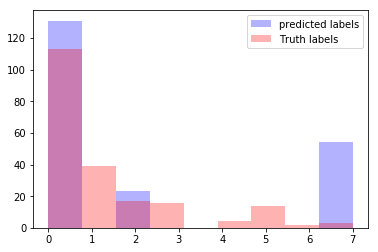

In [62]:
plot_hist_labels(test_predict,test_y)

In [ ]:
# with Hidden_dim =100

In [65]:
def glove_embed(vocab=vocab,word2id=word2id):
#    print('Entered')
    return word_embed #word_embed defined above
tf.reset_default_graph()
class Graph():
    def __init__(self,sent_length,rnn_layers = 1,num_classes = 8):
        self.graph = tf.Graph()
        self.embed_vector = None
        self.hidden = None
        self.dropout = None
        self.logits = None
        self.loss = None
        self.embedded = None
        self.optim = None
        self.accuracy = None
        self.sent_length = sent_length
        self.lrn_rate = None
        self.predict = None
        self.num_classes = num_classes
        self.rnn_layers = rnn_layers
        with self.graph.as_default():
            tf.set_random_seed(1)
            self.X = tf.placeholder(dtype=tf.int32,shape=(None,self.sent_length),name='inputs')
            self.Y = tf.placeholder(dtype=tf.int32,shape=(None,self.num_classes),name='labels')
            self.dropout = tf.placeholder(dtype=tf.float32,shape=(),name='labels')

        
    def Embed_Word(self,len_vocab,embed_attr):
        
        with self.graph.as_default():
            tf.set_random_seed(1)
            if embed_attr == 'random': #Random Embed: LEarn Embed vector while training
                self.embed_vector = tf.Variable(tf.random_normal(shape=(len(vocab),50),seed=1),name='embed_vector',trainable=True)
            elif embed_attr == 'glove-fixed': #Glove-Fixed
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=False) #avoid tf.constant(..): NOT memory efficient.
            elif embed_attr == 'glove-train': #Glove-Trainable: Learn embed_vector while training from fixed Glove embed vector
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=True)
            return 0

    def Create_Graph(self,lrn_rate=0.01,hidden_units=50,n_classes = 8,l2_lambda=0.0001):
        
        def lstm_cell(): #stacking of RNN 
          return tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_units,dropout_keep_prob=self.dropout,layer_norm=False)  

        with self.graph.as_default():
            tf.set_random_seed(1)
            self.embedded = tf.nn.embedding_lookup(self.embed_vector,self.X,name='embedded_word')
            cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(self.rnn_layers)])
            outputs, final_state = tf.nn.dynamic_rnn(cell,tf.cast(self.embedded,tf.float32),dtype=tf.float32)
            logits = tf.contrib.layers.fully_connected(tf.reduce_sum(outputs,axis=1),num_outputs=8,activation_fn=None)
            self.predict = tf.nn.softmax(logits) #softmax can be skipped as we require only the argmax(logits)  
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=self.Y))
            W_loss = tf.add_n([tf.nn.l2_loss(W) for W in tf.trainable_variables() if 'weights' in str(W)])*l2_lambda
            self.loss += W_loss
            global_step = tf.Variable(0,trainable=False)
            self.lrn_rate = tf.cast(lrn_rate,tf.float32)
        #    self.lrn_rate = tf.train.inverse_time_decay(learning_rate=lrn_rate,global_step=global_step,decay_rate=0.05,decay_steps=5) #d_steps = 0.9999
            self.lrn_rate = tf.train.exponential_decay(learning_rate=lrn_rate,global_step=10,decay_steps=9,decay_rate=0.01)
            print('lrn_rate:',lrn_rate)
            self.optim = tf.train.AdamOptimizer(learning_rate=lrn_rate).minimize(self.loss)#,global_step=global_step)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.predict,axis=1),tf.argmax(self.Y,axis=1)),dtype=tf.float32))

        return None

    def Execute_Session(self,train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 2,batch_size=100):
        
        best_val = -1
        loss_hist,val_acc_hist,train_acc_hist = [],[],[]
        tr_loss_hist, val_loss_hist = [],[]
        path = './models/'+file_name
        with tf.Session(graph=self.graph) as sess:
            tf.set_random_seed(1)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            for e in range(num_epoch):
                n, v = 0,0
                num_iter = len(train_X)//batch_size        
                if num_iter == 0:
                    num_iter = len(train_X)

                for i in range(num_iter): #Batches
                    feed_dict = {self.X:train_X[n:n+batch_size,:self.sent_length],self.Y:train_y[n:n+batch_size],self.dropout:dropout}
                    _,tr_loss = sess.run([self.optim,self.loss],feed_dict=feed_dict)
                    n += batch_size

                val_loss_iter = []
                tr_loss,train_acc = sess.run([self.loss,self.accuracy],feed_dict={self.X:train_X[:,:self.sent_length],self.Y:train_y,self.dropout:1.0}) #loss for the entire train
                val_loss,val_acc,lrn_rate = sess.run([self.loss,self.accuracy,self.lrn_rate],feed_dict={self.X:val_X[:,:self.sent_length],self.Y:val_y,self.dropout:1.0})
                val_loss_hist.append(val_loss)
                tr_loss_hist.append(tr_loss)
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                if val_acc > best_val:
                    best_val = val_acc
                    save_path = saver.save(sess,path)

                print('epoch:',e+1,'tr loss:',tr_loss,'val loss:',val_loss,'train acc:',train_acc,'val acc:',val_acc)#, 'with lrn_rate:',lrn_rate)

            embedded = sess.run(self.embed_vector) #to compute T-SNE
            test_acc = sess.run(self.accuracy,feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            print('Test acc. after the complete epoch:',test_acc)    
            print('Best val_acc:',best_val)
            saver.restore(sess, path)
            test_predict,test_acc = sess.run([self.predict,self.accuracy],feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            print('Test acc. with best model:',test_acc)
            test_predict = np.argmax(test_predict,axis=1)
        return (embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict)
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=500,rnn_layers=1,num_classes = 8)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-train')   
    model.Create_Graph(lrn_rate=0.01,hidden_units=100) #New(10/11/2017-Last_Run): hidden_units: 0.50, do=0.5, test=0.586538 num_ep = 30
    file_name = 'practical-3_LSTM_chk_2.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.50,num_epoch = 50,batch_size=50)

lrn_rate: 0.01
epoch: 1 tr loss: 16.0449 val loss: 20.367 train acc: 0.518675 val acc: 0.495192
epoch: 2 tr loss: 3.91136 val loss: 6.26353 train acc: 0.60241 val acc: 0.475962
epoch: 3 tr loss: 3.10408 val loss: 6.86942 train acc: 0.609036 val acc: 0.408654
epoch: 4 tr loss: 1.90924 val loss: 6.09632 train acc: 0.709639 val acc: 0.418269
epoch: 5 tr loss: 2.45394 val loss: 7.74978 train acc: 0.722289 val acc: 0.413462
epoch: 6 tr loss: 0.68755 val loss: 8.21939 train acc: 0.898193 val acc: 0.548077
epoch: 7 tr loss: 0.143903 val loss: 7.50341 train acc: 0.969277 val acc: 0.572115
epoch: 8 tr loss: 0.061107 val loss: 8.04513 train acc: 0.987349 val acc: 0.615385
epoch: 9 tr loss: 0.013036 val loss: 7.17155 train acc: 0.99759 val acc: 0.610577
epoch: 10 tr loss: 0.0106222 val loss: 7.9878 train acc: 0.99759 val acc: 0.605769
epoch: 11 tr loss: 0.00752849 val loss: 7.52756 train acc: 0.999398 val acc: 0.610577
epoch: 12 tr loss: 0.00827782 val loss: 7.32752 train acc: 0.999398 val acc: 0

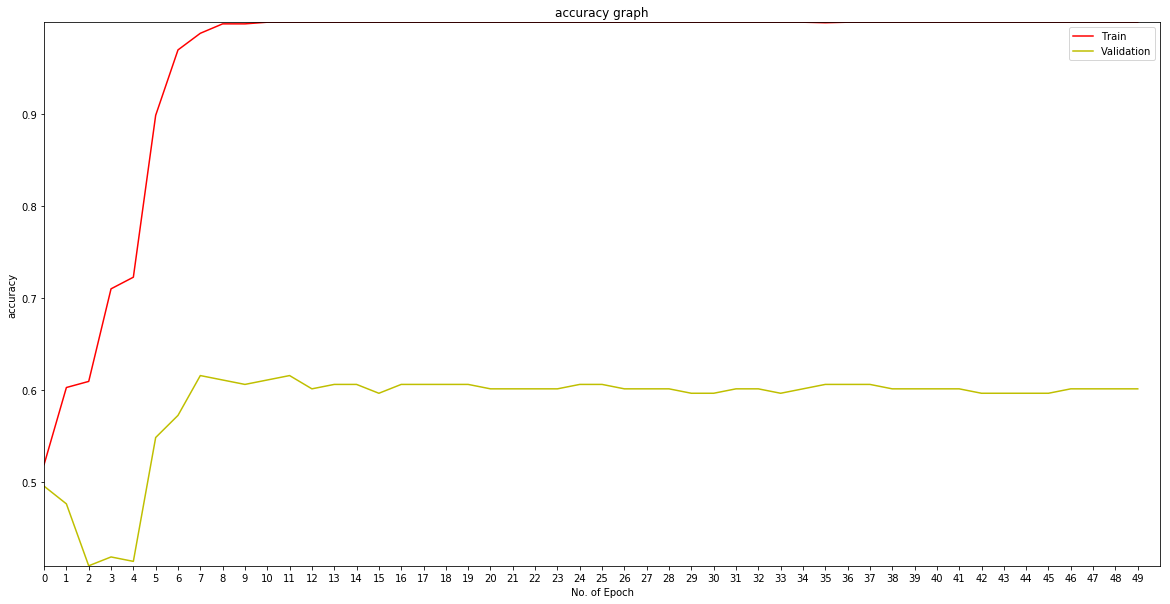

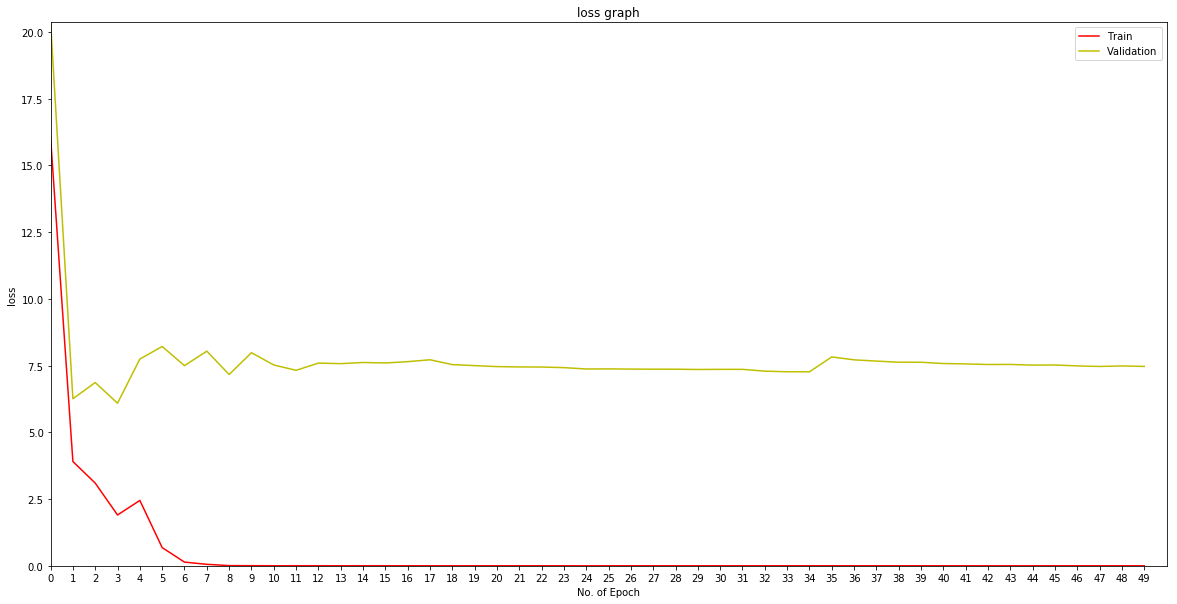

In [66]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

bincount(test_predict) [156  18  12  12   0   7   0   3]
bincount(test_label) [113  39  17  16   4  14   2   3]


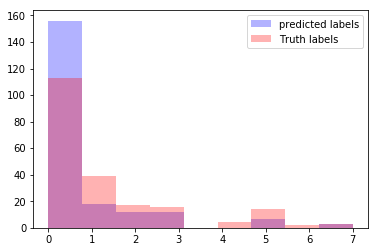

In [67]:
plot_hist_labels(test_predict,test_y)

It starts to overfit but I did try with lesser complex classes by training with less hidden units which resulted in attaining lower test accuracy.  

# Bi-LSTM Implementation

In [28]:
def glove_embed(vocab=vocab,word2id=word2id):
    return word_embed

tf.reset_default_graph()
class Graph():
    def __init__(self,sent_length,rnn_layers = 1,num_classes = 8):
        self.graph = tf.Graph()
        self.embed_vector = None
        self.hidden = None
        self.dropout = None
        self.logits = None
        self.loss = None
        self.embedded = None
        self.optim = None
        self.accuracy = None
        self.lrn_rate = None
        self.predict = None
        self.sent_length = sent_length
        self.num_classes = num_classes
        self.rnn_layers = rnn_layers
        with self.graph.as_default():
            tf.set_random_seed(1)
            self.X = tf.placeholder(dtype=tf.int32,shape=(None,self.sent_length),name='inputs')
            self.Y = tf.placeholder(dtype=tf.int32,shape=(None,self.num_classes),name='labels')
            self.dropout = tf.placeholder(dtype=tf.float32,shape=(),name='labels')

        
    def Embed_Word(self,len_vocab,embed_attr):
        
        with self.graph.as_default():
            tf.set_random_seed(1)
            if embed_attr == 'random': #Random Embed: LEarn Embed vector while training
                self.embed_vector = tf.Variable(tf.random_normal(shape=(len(vocab),50),seed=1),name='embed_vector',trainable=True)
            elif embed_attr == 'glove-fixed': #Glove-Fixed
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=False) #avoid tf.constant(..): NOT memory efficient.
            elif embed_attr == 'glove-train': #Glove-Trainable: Learn embed_vector while training from fixed Glove embed vector
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=True)
            return 0

    def Create_Graph(self,lrn_rate=0.01,hidden_units=50,n_classes = 8,l2_lambda=0.0001):
        
        def lstm_cell(): #stacking of RNN 
          return tf.contrib.rnn.BasicLSTMCell(hidden_units)  
        with self.graph.as_default():
            tf.set_random_seed(1)
            self.embedded = tf.nn.embedding_lookup(self.embed_vector,self.X,name='embedded_word')
            cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(self.rnn_layers)])
            fw_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell(),output_keep_prob=self.dropout,seed=1)
            bw_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell(),output_keep_prob=self.dropout,seed=1)
            outputs, final_state = tf.nn.bidirectional_dynamic_rnn(fw_cell,bw_cell,tf.cast(self.embedded,tf.float32),dtype=tf.float32)
            print('outputs.shape:',outputs)
            outputs_rnn = tf.concat(outputs,axis=2)
            print('outputs_rnn.shape:',outputs_rnn.shape)
            output_rnn_pooled = tf.reduce_mean(outputs_rnn,axis=1)
            print('output_rnn_pooled.shape:',output_rnn_pooled.shape)
            logits = tf.contrib.layers.fully_connected(output_rnn_pooled,num_outputs=8,activation_fn=None)
            self.predict = tf.nn.softmax(logits)   
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=self.Y))
            print('tf.trainable_variables:',[W for W in tf.trainable_variables() if 'weights' in str(W)])
            W_loss = tf.add_n([tf.nn.l2_loss(W) for W in tf.trainable_variables() if 'weights' in str(W)])*l2_lambda
            self.loss += W_loss
            global_step = tf.Variable(0,trainable=False)
            self.lrn_rate = tf.cast(lrn_rate,tf.float32)
#            self.lrn_rate = tf.train.inverse_time_decay(learning_rate=lrn_rate,global_step=global_step,decay_rate=0.05,decay_steps=5) #d_steps = 0.9999
            self.lrn_rate = tf.train.exponential_decay(learning_rate=lrn_rate,global_step=10,decay_steps=9,decay_rate=0.01)
            print('lrn_rate:',self.lrn_rate)
            self.optim = tf.train.AdamOptimizer(learning_rate=self.lrn_rate).minimize(self.loss,global_step=global_step)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.predict,axis=1),tf.argmax(self.Y,axis=1)),dtype=tf.float32))

        return None

    def Execute_Session(self,train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 2,batch_size=100):
        
        best_val = -1
        loss_hist,val_acc_hist,train_acc_hist = [],[],[]
        tr_loss_hist, val_loss_hist = [],[]
        path = './models/'+file_name
        with tf.Session(graph=self.graph) as sess:
            tf.set_random_seed(1)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            for e in range(num_epoch):
                n, v = 0,0
                num_iter = len(train_X)//batch_size        
                if num_iter == 0:
                    num_iter = len(train_X)

                for i in range(num_iter): #Batches
                    feed_dict = {self.X:train_X[n:n+batch_size,:self.sent_length],self.Y:train_y[n:n+batch_size],self.dropout:dropout}
                    _,tr_loss = sess.run([self.optim,self.loss],feed_dict=feed_dict)
                    n += batch_size

                val_loss_iter = []
                tr_loss,train_acc = sess.run([self.loss,self.accuracy],feed_dict={self.X:train_X[:,:self.sent_length],self.Y:train_y,self.dropout:1.0}) #loss for the entire train
                val_loss,val_acc,lrn_rate = sess.run([self.loss,self.accuracy,self.lrn_rate],feed_dict={self.X:val_X[:,:self.sent_length],self.Y:val_y,self.dropout:1.0})
                val_loss_hist.append(val_loss)
                tr_loss_hist.append(tr_loss)
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                if val_acc >= best_val:
                    best_val = val_acc
                    save_path = saver.save(sess,path)

                print('epoch:',e+1,'tr loss:',tr_loss,'val loss:',val_loss,'train acc:',train_acc,'val acc:',val_acc)#, 'with lrn_rate:',lrn_rate)
                    
            embedded = sess.run(self.embed_vector) #to compute T-SNE
#            print('embedded.shape',embedded.shape)
            print('Best val_acc:',best_val)
            saver.restore(sess, path)
            test_predict,test_acc = sess.run([self.predict,self.accuracy],feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            test_predict = np.argmax(test_predict,axis=1)
            print('Test acc. with best model:',test_acc)    
        return (embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict)
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=500,rnn_layers=1,num_classes = 8) #rnn_lyr =1 ==>0.61
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-train') #glove-fixed: test_acc:0.524, do=0.5, hidd=35,lrn=0.03    
    model.Create_Graph(lrn_rate=0.01,hidden_units=100) #glove-train: 0.56, do=0.7, lrn=0.02,hid=35
    file_name = 'practical-3_BiLSTM_chk_1.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist,test_predict = \
   model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.50,num_epoch = 50,batch_size=50)

outputs.shape: (<tf.Tensor 'bidirectional_rnn/fw/fw/transpose:0' shape=(?, 500, 100) dtype=float32>, <tf.Tensor 'ReverseV2:0' shape=(?, 500, 100) dtype=float32>)
outputs_rnn.shape: (?, 500, 200)
output_rnn_pooled.shape: (?, 200)
tf.trainable_variables: [<tf.Variable 'fully_connected/weights:0' shape=(200, 8) dtype=float32_ref>]
lrn_rate: Tensor("ExponentialDecay:0", shape=(), dtype=float32)
epoch: 1 tr loss: 1.7337 val loss: 1.73926 train acc: 0.544578 val acc: 0.543269
epoch: 2 tr loss: 1.51693 val loss: 1.53342 train acc: 0.544578 val acc: 0.543269
epoch: 3 tr loss: 1.41469 val loss: 1.43897 train acc: 0.544578 val acc: 0.548077
epoch: 4 tr loss: 1.37356 val loss: 1.40185 train acc: 0.54759 val acc: 0.552885
epoch: 5 tr loss: 1.34509 val loss: 1.37784 train acc: 0.549398 val acc: 0.548077
epoch: 6 tr loss: 1.32012 val loss: 1.3581 train acc: 0.55 val acc: 0.552885
epoch: 7 tr loss: 1.29373 val loss: 1.33814 train acc: 0.553614 val acc: 0.552885
epoch: 8 tr loss: 1.26082 val loss: 1.3

In [29]:
p = figure(title="loss graph", y_axis_type="linear",y_range=(min(tr_loss_hist),max(tr_loss_hist)))

p.line(range(len(tr_loss_hist)), tr_loss_hist, legend="training loss",
       line_color="tomato",line_width=2)

p.line(range(len(val_loss_hist)), val_loss_hist, legend="val loss",
       line_color="gold", line_width=2)

p.legend.location = "top_right"

p.xaxis.axis_label = 'Iterations'
p.yaxis.axis_label = 'Error'

output_file("loss_graph.html", title="loss graph")
show(gridplot(p, ncols=20, plot_width=600, plot_height=600))

In [30]:
p = figure(title="acc graph", y_axis_type="linear",
           y_range=(min(train_acc_hist),max(max(train_acc_hist),max(val_acc_hist))))
p.line(range(len(train_acc_hist)), train_acc_hist, legend="training acc",
       line_color="tomato",line_width=2)

p.line(range(len(val_acc_hist)), val_acc_hist, legend="val acc",
       line_color="gold", line_width=2)

p.legend.location = "top_right"

p.xaxis.axis_label = 'Epoch'
p.yaxis.axis_label = 'Acc.'

output_file("acc_graph.html", title="Acc. graph")
show(gridplot(p, ncols=20, plot_width=800, plot_height=800))

bincount(test_predict) [144  35  11  14   0   4]
bincount(test_label) [113  39  17  16   4  14   2   3]


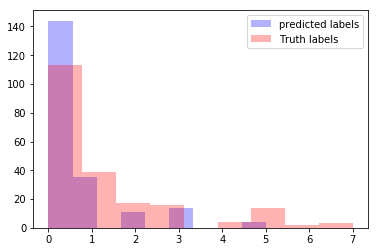

In [73]:
plot_hist_labels(test_predict,test_y)

Though BiDirectional LSTM avoids overfitting but the test accuracy haven't much improved in comparision to vanilla LSTM. 
Have to play further with the hyperparameters; will update once i attain better results.